In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import re
from Constants import *
import simplejson
from Preprocessing import *
from Utils import *
from Classifiers import *
from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score, precision_recall_fscore_support
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
decision_model,transition_model1,transition_model2, outcome_model, soutcome_model = load_models()
dataset = DTDataset()
decision_model

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DecisionAttentionModel(
  (input_dropout): Dropout(p=0.25, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=1000, bias=True)
  )
  (batchnorm): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (relu): Softplus(beta=1, threshold=20)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
  (final_opt_layer): Linear(in_features=1000, out_features=100, bias=True)
  (final_imitation_layer): Linear(in_features=1000, out_features=100, bias=True)
  (final_layer): Linear(in_features=1000, out_features=6, bias=True)
  (resize_layer): Linear(in_features=91, out_features=100, bias=True)
  (attentions): ModuleList(
    (0): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
  )
  (norms): ModuleList(
    (0): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  )
  (activation): ReLU()
)

In [4]:
[len(x) for x in get_tt_split()]

[389, 147]

In [5]:
Const.dlt1

['DLT_Neurological',
 'DLT_Hematological',
 'DLT_Dermatological',
 'DLT_Other',
 'DLT_Gastrointestinal']

In [6]:
def evaluate_transition_model(model,state,ensemble=True,dataset=None):
    [xtrain,xtest, ytrain,ytest] = transition_sample(state,dataset=dataset)
    xtest = xtest.to(model.get_device())
    ytest = [yy.to(model.get_device()) for yy in ytest]
    if ensemble:
        ypred = model(xtest)['predictions']
    else:
        ypred = model(xtest)
    if state < 3:
        metrics = state_metrics(ytest,ypred)
    else:
        metrics = outcome_metrics(ytest,ypred)
    return metrics


In [7]:
def unravel_result(res):
    res = format_main_result(res,as_df=False)
    r2 = {}
    for key,value in res.items():
        for key2, value2 in value.items():
            r2[key+'_'+key2] = value2
    return r2

import seaborn as sns
import matplotlib.pyplot as plt
def vis_ensemble_results(resultlist,ax=None):
    plotstuff = []
    for r in resultlist[1]:
        rr = unravel_result(r)
        for k,v in rr.items():
            entry = {'name': k,'value': v,'resampled': False}
            plotstuff.append(entry)
    for r in resultlist[-1]:
        rr = unravel_result(r)
        for k,v in rr.items():
            entry = {'name': k,'value': v,'resampled': True}
            plotstuff.append(entry)
#     plotstuff = [v for v in plotstuff if 'accuracy' not in v['name'] and 'mse' not in v['name']]
    plotstuff = [v for v in plotstuff if 'auc_mean' in v['name'] or v['name'][len(v['name'])-3:] == 'auc']
    tempdf = pd.DataFrame(plotstuff)
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(10,10))
    sns.boxplot(
        data=tempdf,
        orient='h',
        hue='resampled',
        x='value',
        y='name',
        ax=ax,
    )
    ax.set_xlim(.3,1)
# fig,axes = plt.subplots(1,3,figsize=(60,20))
# for i,model in enumerate([transition_model1,transition_model2,outcome_model]):
#     results = evaluate_ensemble(model,i+1,dataset=dataset)
#     vis_ensemble_results(results,ax=axes[i])

In [8]:
def calc_optimal_decisions(dataset,ids,m1,m2,m3,weights=[-1,1,1,-1],outcome_loss_func=None,get_transitions=True):
    m1.eval()
    m2.eval()
    m3.eval()
    device = m1.get_device()
    data = dataset.processed_df.copy().loc[ids]
    
    def get_dlt(state):
        if state == 2:
            return data[Const.dlt2].copy()
        d = data[Const.dlt1].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_pd(state):
        if state == 2:
            return data[Const.primary_disease_states2].copy()
        d = data[Const.primary_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_nd(state):
        if state == 2:
            return data[Const.nodal_disease_states2].copy()
        d = data[Const.nodal_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_cc(state):
        res = data[Const.ccs].copy()
        if state == 1:
            res.values[:,:] = np.zeros(res.values.shape)
        return res
    
    def get_mod(state):
        res = data[Const.modifications].copy()
        #this should have an ic condition but we don't use it anumore anywa
        return res
        
    def formatdf(d):
        d = df_to_torch(d).to(device)
        return d
    
    
    outcomedf = data[Const.outcomes]
    baseline = dataset.get_state('baseline').loc[ids]
    baseline_input = formatdf(baseline)

    
    def outcome_loss(ypred):
        l = torch.mul((-1*(ypred[:,0] - 1)),-weights[0])
        for i,weight in enumerate(weights[1:]):
            #weights with negative values will invert the outcome so e.g. Regional control becomes no regional control
            #so the penaly is correct
            if weight > 0:
                newloss = torch.mul(ypred[:,i],weight)
            else:
                newloss = torch.mul(-1*(ypred[:,i] - 1),-weights[i])
            l = torch.add(l,newloss)
        return l
    if outcome_loss_func is None:
        outcome_loss_func = outcome_loss
    
    cat = lambda x: torch.cat([xx.to(device) for xx in x],axis=1).to(device)
    format_transition = lambda x: x.to(device)
    
    def get_outcome(d1,d2,d3):
        d1 = torch.full((len(ids),1),d1).type(torch.FloatTensor)
        d2 = torch.full((len(ids),1),d2).type(torch.FloatTensor)
        d3 = torch.full((len(ids),1),d3).type(torch.FloatTensor)
        
        tinput1 = cat([baseline_input,d1])
        ytransition = m1(tinput1)
        [ypd1,ynd1,ymod,ydlt1] = [format_transition(xx) for xx in ytransition['predictions']]
        d1_thresh = torch.gt(d1,.5).view(-1,1).to(device)
        ypd1[:,0:2] = ypd1[:,0:2]*d1_thresh
        ynd1[:,0:2] = ynd1[:,0:2]*d1_thresh
        
        tinput2 = cat([baseline_input,ypd1,ynd1,ymod,ydlt1,d1,d2])
        ytransition2 = m2(tinput2)
        [ypd2,ynd2,ycc,ydlt2] = [format_transition(xx) for xx in ytransition2['predictions']]
        
        input3 = cat([baseline_input, ypd2, ynd2, ycc, ydlt2, d1, d2,d3])
        outcome = m3(input3)['predictions']
        transitions = {
            'pd1': ypd1,
            'nd1': ynd1,
            'nd2': ynd2,
            'pd2': ypd2,
            'mod': ymod,
            'cc': ycc,
            'dlt1': ydlt1,
            'dlt2': ydlt2,
        }
        return outcome, transitions

    losses = []
    loss_order = []
    transitions = {}
    for d1 in [0,1]:
        for d2 in [0,1]:
            for d3 in [0,1]:
                outcomes, transition_entry = get_outcome(d1,d2,d3)
                loss = outcome_loss_func(outcomes)
                losses.append(loss)
                loss_order.append([d1,d2,d3])
                transitions[str(d1)+str(d2)+str(d3)] = transition_entry
    losses = torch.stack(losses,axis=1)
    optimal_decisions = [loss_order[i] for i in torch.argmin(losses,axis=1)]
    result = torch.tensor(optimal_decisions).type(torch.FloatTensor)
    if get_transitions:
        opt_transitions = {k: torch.zeros(v.shape).type(torch.FloatTensor) for k,v in transitions['000'].items()}
        for i,od in enumerate(optimal_decisions):
            key = ''.join([str(o) for o in od])
            entry = transitions[key]
            for kk,vv in entry.items():
                opt_transitions[kk][i,:] = vv[i,:]
        return result, opt_transitions
    return result

def eval_decision_model(model,tmodel1,tmodel2,tmodel3,dataset=None):
    if dataset is None:
        dataset = DTDataset()
        
    data = dataset.processed_df.copy()
    
    train_ids, test_ids = get_tt_split(dataset)

    def get_dlt(state):
        if state == 2:
            return data[Const.dlt2].copy()
        d = data[Const.dlt1].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_pd(state):
        if state == 2:
            return data[Const.primary_disease_states2].copy()
        d = data[Const.primary_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_nd(state):
        if state == 2:
            return data[Const.nodal_disease_states2].copy()
        d = data[Const.nodal_disease_states].copy()
        if state < 1:
            d.values[:,:] = 0
        return d
    
    def get_cc(state):
        res = data[Const.ccs].copy()
        if state == 1:
            res.values[:,:] = np.zeros(res.values.shape)
        return res
    
    def get_mod(state):
        res = data[Const.modifications].copy()
        #this should have an ic condition but we don't use it anumore anywa
        return res
        
    outcomedf = data[Const.outcomes]
    baseline = dataset.get_state('baseline')
    
    def formatdf(d,dids=train_ids):
        d = df_to_torch(d.loc[dids]).to(model.get_device())
        return d
    
    def remove_decisions(df):
        cols = [c for c in df.columns if c not in Const.decisions ]
        ddf = df[cols]
        return ddf
    
    makeinput = lambda step,dids: df_to_torch(remove_decisions(dataset.get_input_state(step=step,ids=dids)))
    
    y = df_to_torch(outcomedf.loc[test_ids])
    xxtrained = [baseline, get_dlt(0),get_dlt(0),get_pd(0),get_nd(0),get_cc(0),get_mod(0)]
    xxtrain = [formatdf(xx,test_ids) for xx in xxtrained]
    
    usemem = hasattr(model,'memory')
    if usemem:
        o1 = model(torch.cat(xxtrain,axis=1),position=0,use_saved_memory = True)
    else:
        o1 = model(torch.cat(xxtrain,axis=1),position=0)
    decision1_imitation = o1[:,3]
    
    x1_imitation = [baseline, get_dlt(1),get_dlt(0),get_pd(1),get_nd(1),get_cc(1),get_mod(1)]
    x1_imitation = [formatdf(xx1,test_ids) for xx1 in x1_imitation]
    
    if usemem:
        decision2_imitation = model(torch.cat(x1_imitation,axis=1),position=1,use_saved_memory = True)[:,4]
    else:
        decision2_imitation = model(torch.cat(x1_imitation,axis=1),position=1)[:,4]
        
    x2_imitation = [baseline, get_dlt(1),get_dlt(2),get_pd(2),get_nd(2),get_cc(2),get_mod(2)]
        
    x2_imitation = [formatdf(xx2,test_ids) for xx2 in x2_imitation]
    
    if usemem:
        decision3_imitation = model(torch.cat(x2_imitation,axis=1),position=2,use_saved_memory = True)[:,5]
    else:
        decision3_imitation = model(torch.cat(x2_imitation,axis=1),position=2)[:,5]
    
        
    y_opt, transition_dict = calc_optimal_decisions(dataset,test_ids,tmodel1,tmodel2,tmodel3)
    decision1_opt = o1[:,0]
    
    opt_input2 = [
            formatdf(baseline,test_ids), 
            transition_dict['dlt1'],
            formatdf(get_dlt(0),test_ids),
            transition_dict['pd1'],
            transition_dict['nd1'], 
            formatdf(get_cc(0),test_ids),
            transition_dict['mod']
                 ]
    opt_input2 = torch.cat(opt_input2,axis=1)
    if usemem:
        decision2_opt = model(opt_input2,position=1,use_save_memory=True)[:,1]
    else:
        decision2_opt = model(opt_input2,position=1)[:,1]
    opt_input3 = [
            formatdf(baseline,test_ids),
            transition_dict['dlt1'],
            transition_dict['dlt2'],
            transition_dict['pd2'],
            transition_dict['nd2'],
            transition_dict['cc'],
            transition_dict['mod'],
        ]
    opt_input3 = torch.cat(opt_input3,axis=1)
    if usemem:
        decision3_opt = model(opt_input3,position=2,use_saved_memory=True)[:,2]
    else:
        decision3_opt = model(opt_input3,position=2)[:,2]
    
    scores = []
    imitation = [decision1_imitation,decision2_imitation,decision3_imitation]
    optimal = [decision1_opt,decision2_opt,decision3_opt]
    for i,decision_im in enumerate(imitation):
        deci = decision_im.cpu().detach().numpy()
        deci0 = (deci > .5).astype(int)
        iout = y[:,i].cpu().detach().numpy()
        acci = accuracy_score(iout,deci0)
        try:
            auci = roc_auc_score(iout,deci)
        except:
            auci = -1

        deco = optimal[i].cpu().detach().numpy()
        deci0 = (deco > .5).astype(int)
        oout = y_opt[:,i].cpu().detach().numpy()
        acco = accuracy_score(oout,deci0)
        try:
            auco = roc_auc_score(oout,deco)
        except:
            auco=-1
        scores.append({'decision': i,'optimal_auc': auco,'imitation_auc': auci,'optimal_acc': acco,'imitation_acc': acci})
    return scores

eval_decision_model(decision_model,transition_model1,transition_model2,outcome_model)

TypeError: forward() got an unexpected keyword argument 'use_save_memory'

In [9]:
#how an svc performs
def mc_svc_baseline(dataset,model,outcome='pd_states1',class_weight='balanced',**svc_args):
    state = 0
    if outcome in ['pd_states1','nd_states1']:
        state = 1
    elif outcome in ['pd_states2','nd_states2']:
        state = 2
    else:
        print('nope')
        return
    train_ids, test_ids = get_tt_split(dataset)
    xtrain = dataset.get_input_state(step=state,ids=train_ids)
    xtest = dataset.get_input_state(step=state,ids=test_ids)
    ytrain = dataset.get_state(outcome,ids=train_ids)
    ytest= dataset.get_state(outcome,ids=test_ids)
    ytrain = np.argmax(ytrain.values,axis=1)
    ytest = np.argmax(ytest.values,axis=1)
        
    normalize = lambda x: (x - xtrain.values.mean(axis=0))/(xtrain.values.std(axis=0)+.0001)
    if model is None:
        model = SVC(**svc_args,probability=True,class_weight=class_weight,random_state=0)
    model.fit(xtrain,ytrain)
    ypred= model.predict_proba(xtest)
    return baseline_mc_metrics(ytest,ypred)

def eval_svcs_progression(dataset,model=None,**args):
    res = {}
    for state in [1,2]:
        for outcome in ['pd','nd']:
            name = outcome+'_states'+str(state)
            results = mc_svc_baseline(dataset,model=model,outcome=outcome+'_states'+str(state),**args)
            res[name] = results
    return res

eval_svcs_progression(dataset, model=RandomForestClassifier(100),kernel='linear', class_weight='balanced')

{'pd_states1': {'accuracy': 0.4821288515406163,
  'auc_micro': 0.7493020295549914,
  'auc_mean': 0.7493020295549914,
  'auc_weighted': 0.9196433550000795},
 'nd_states1': {'accuracy': 0.6063636363636363,
  'auc_micro': 0.8722632192498095,
  'auc_mean': 0.8722632192498095,
  'auc_weighted': 0.9442592516475937},
 'pd_states2': {'accuracy': 0.3306233062330623,
  'auc_micro': 0.6025062496265289,
  'auc_mean': 0.6025062496265289,
  'auc_weighted': 0.6758131150530621},
 'nd_states2': {'accuracy': 0.34040895813047717,
  'auc_micro': 0.6003684863374749,
  'auc_mean': 0.6003684863374749,
  'auc_weighted': 0.4979410124483398}}

In [10]:

def boolean_outcomes(dataset,model = None,calibrate=True,**model_args):
    if model is None:
        model = SVC(probability=True,random_state=0,**model_args)
    if calibrate:
        model = CalibratedClassifierCV(model,cv=3)
    targets = ['decision1','decision2','decision3','survival','ft','aspiration','lr_control']
    train_ids, test_ids = get_tt_split(dataset)
    results = {}
    
    def run_target(xtrain,xtest,ytrain,ytest):
        model.fit(xtrain,ytrain)
        ypred = model.predict_proba(xtest)[:,1]
        ypred_bool = model.predict(xtest)
        metrics = boolean_metrics(ytest,ypred,ypred_bool)
        metrics['model'] = clone(model)
        return metrics
    
    for target in targets:
        state = 3
        if target == 'decision1':
            state = 0
        elif target == 'decision2':
            state = 1
        elif target == 'decision3':
            state = 2
        xtrain = dataset.get_input_state(step=state,ids=train_ids)
        xtest = dataset.get_input_state(step=state,ids=test_ids)
        ytrain = dataset.get_state(target,ids=train_ids)
        ytest= dataset.get_state(target,ids=test_ids)
        results[target] = run_target(xtrain,xtest,ytrain,ytest)
        
    for target in Const.dlt1 + Const.dlt2:
        state = 0 if target in Const.dlt1 else 1
        xtrain = dataset.get_input_state(step=state,ids=train_ids)
        xtest =  dataset.get_input_state(step=state,ids=test_ids)
        y = dataset.processed_df[target]
        ytrain = y.loc[train_ids]
        ytest = y.loc[test_ids]
        if ytrain.sum() > 0 and ytest.sum() > 0:
            results[target] = run_target(xtrain,xtest,ytrain,ytest)
    return results

def eval_outcomes(dataset,model=None,calibrate=True,**model_args):
    if model is None:
        model = SVC(probability=True,random_state=0,**model_args)
    if calibrate:
        calibrated_model = CalibratedClassifierCV(model,cv=3)
        boolean_results = boolean_outcomes(dataset,model=calibrated_model,calibrate=False)
    else:
        boolean_results = boolean_outcomes(dataset,model=model,calibrate=False)
    #dont calibrate these because it breaks
    mc_results = eval_svcs_progression(dataset,model=model)
    for k,v in mc_results.items():
        v['auc'] = v['auc_micro']
        v['model'] = clone(model)
        boolean_results[k] = v
    return boolean_results

from Models import *
from Classifiers import *
svc_results = []
# for [name,altmodel] in [['nca',MetricLearningClassifier()],['bayeswrapper',BayesWrapper()]]:
#     results = eval_outcomes(dataset,model=altmodel,calibrate=False)
#     for k,v in results.items():
#         entry = {kk:vv for kk,vv in v.items()}
#         entry['outcome'] = k
#         entry['modelname'] =name
#         svc_results.append(entry)
#     print(name,results)
# print('alt models done')
# for kernel in ['linear','rbf','poly']:
#     for c in [.1,1,10]:
#         results = eval_outcomes(dataset,class_weight='balanced',kernel=kernel,C=c)
#         for k,v in results.items():
#             entry = {kk:vv for kk,vv in v.items()}
#             entry['outcome'] = k
#             entry['modelname'] ='svc-' + kernel + '-C:'+str(c)
#             svc_results.append(entry)
            
# print('svc done',svc_results)
# for n in [100]:
#     print(n)
#     for max_depth in [4,10]:
#         for min_split in [2,5]:
#             for criterion in ['gini']:
#                 model = RandomForestClassifier(n_estimators=n,max_depth = max_depth,min_samples_split=min_split,class_weight='balanced',random_state=0)
#                 results = eval_outcomes(dataset,model=model)
#                 for k,v in results.items():
#                     entry = {kk:vv for kk,vv in v.items()}
#                     entry['outcome'] = k
#                     entry['modelname'] ='tree-'+criterion+'-' +str(n) + '-'+'depth:'+str(max_depth)+'-minsplit:'+str(min_split)
#                     svc_results.append(entry)
#     for alpha in [.0001,.001,.01]:
#         model2 = MLPClassifier(hidden_layer_sizes=n,random_state=0,early_stopping=True,solver='adam',alpha=alpha)
#         results = eval_outcomes(dataset,model=model2)
#         for k,v in results.items():
#             entry = {kk:vv for kk,vv in v.items()}
#             entry['outcome'] = k
#             entry['modelname'] ='mlp-' +str(n)+'-alpha:'+ str(alpha)
#             svc_results.append(entry)
# svc_results = pd.DataFrame(svc_results)
# print('done')

In [11]:
# import time
# def save_run_results(df):
#     name = '../results/transition_run_' + str(time.time()) + '.csv'
#     df.to_csv(name,index=False)
#     return name

# save_run_results(svc_results)

AttributeError: 'list' object has no attribute 'to_csv'

In [12]:
svc_results = pd.read_csv('../results/transition_run_1697135406.1157553.csv')
svc_results

,Unnamed: 0,auc,f1,precision,recall,model,outcome,modelname,accuracy,auc_micro,auc_mean,auc_weighted
0,0,0.772370,0.621359,0.680851,0.571429,"CalibratedClassifierCV(cv=3,\n ...",decision1,svc-linear-C:0.1,NaN,NaN,NaN,NaN
1,1,0.812390,0.888000,0.840909,0.940678,"CalibratedClassifierCV(cv=3,\n ...",decision2,svc-linear-C:0.1,NaN,NaN,NaN,NaN
2,2,0.498526,0.000000,0.000000,0.000000,"CalibratedClassifierCV(cv=3,\n ...",decision3,svc-linear-C:0.1,NaN,NaN,NaN,NaN
3,3,0.600191,0.942446,0.891156,1.000000,"CalibratedClassifierCV(cv=3,\n ...",survival,svc-linear-C:0.1,NaN,NaN,NaN,NaN
4,4,0.690761,0.060606,1.000000,0.031250,"CalibratedClassifierCV(cv=3,\n ...",ft,svc-linear-C:0.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1066,1066,0.725510,0.000000,0.000000,0.000000,"CalibratedClassifierCV(cv=3,\n ...",DLT_Hematological 2,mlp-500-alpha:0.01,NaN,NaN,NaN,NaN
1067,1067,0.332688,NaN,NaN,NaN,"MLPClassifier(alpha=0.01, early_stopping=True,...",pd_states1,mlp-500-alpha:0.01,0.333333,0.332688,0.332688,0.354208
1068,1068,0.369059,NaN,NaN,NaN,"MLPClassifier(alpha=0.01, early_stopping=True,...",nd_states1,mlp-500-alpha:0.01,0.333333,0.369059,0.369059,0.441639
1069,1069,0.550940,NaN,NaN,NaN,"MLPClassifier(alpha=0.01, early_stopping=True,...",pd_states2,mlp-500-alpha:0.01,0.333333,0.550940,0.550940,0.488145


(0.5, 1.0)

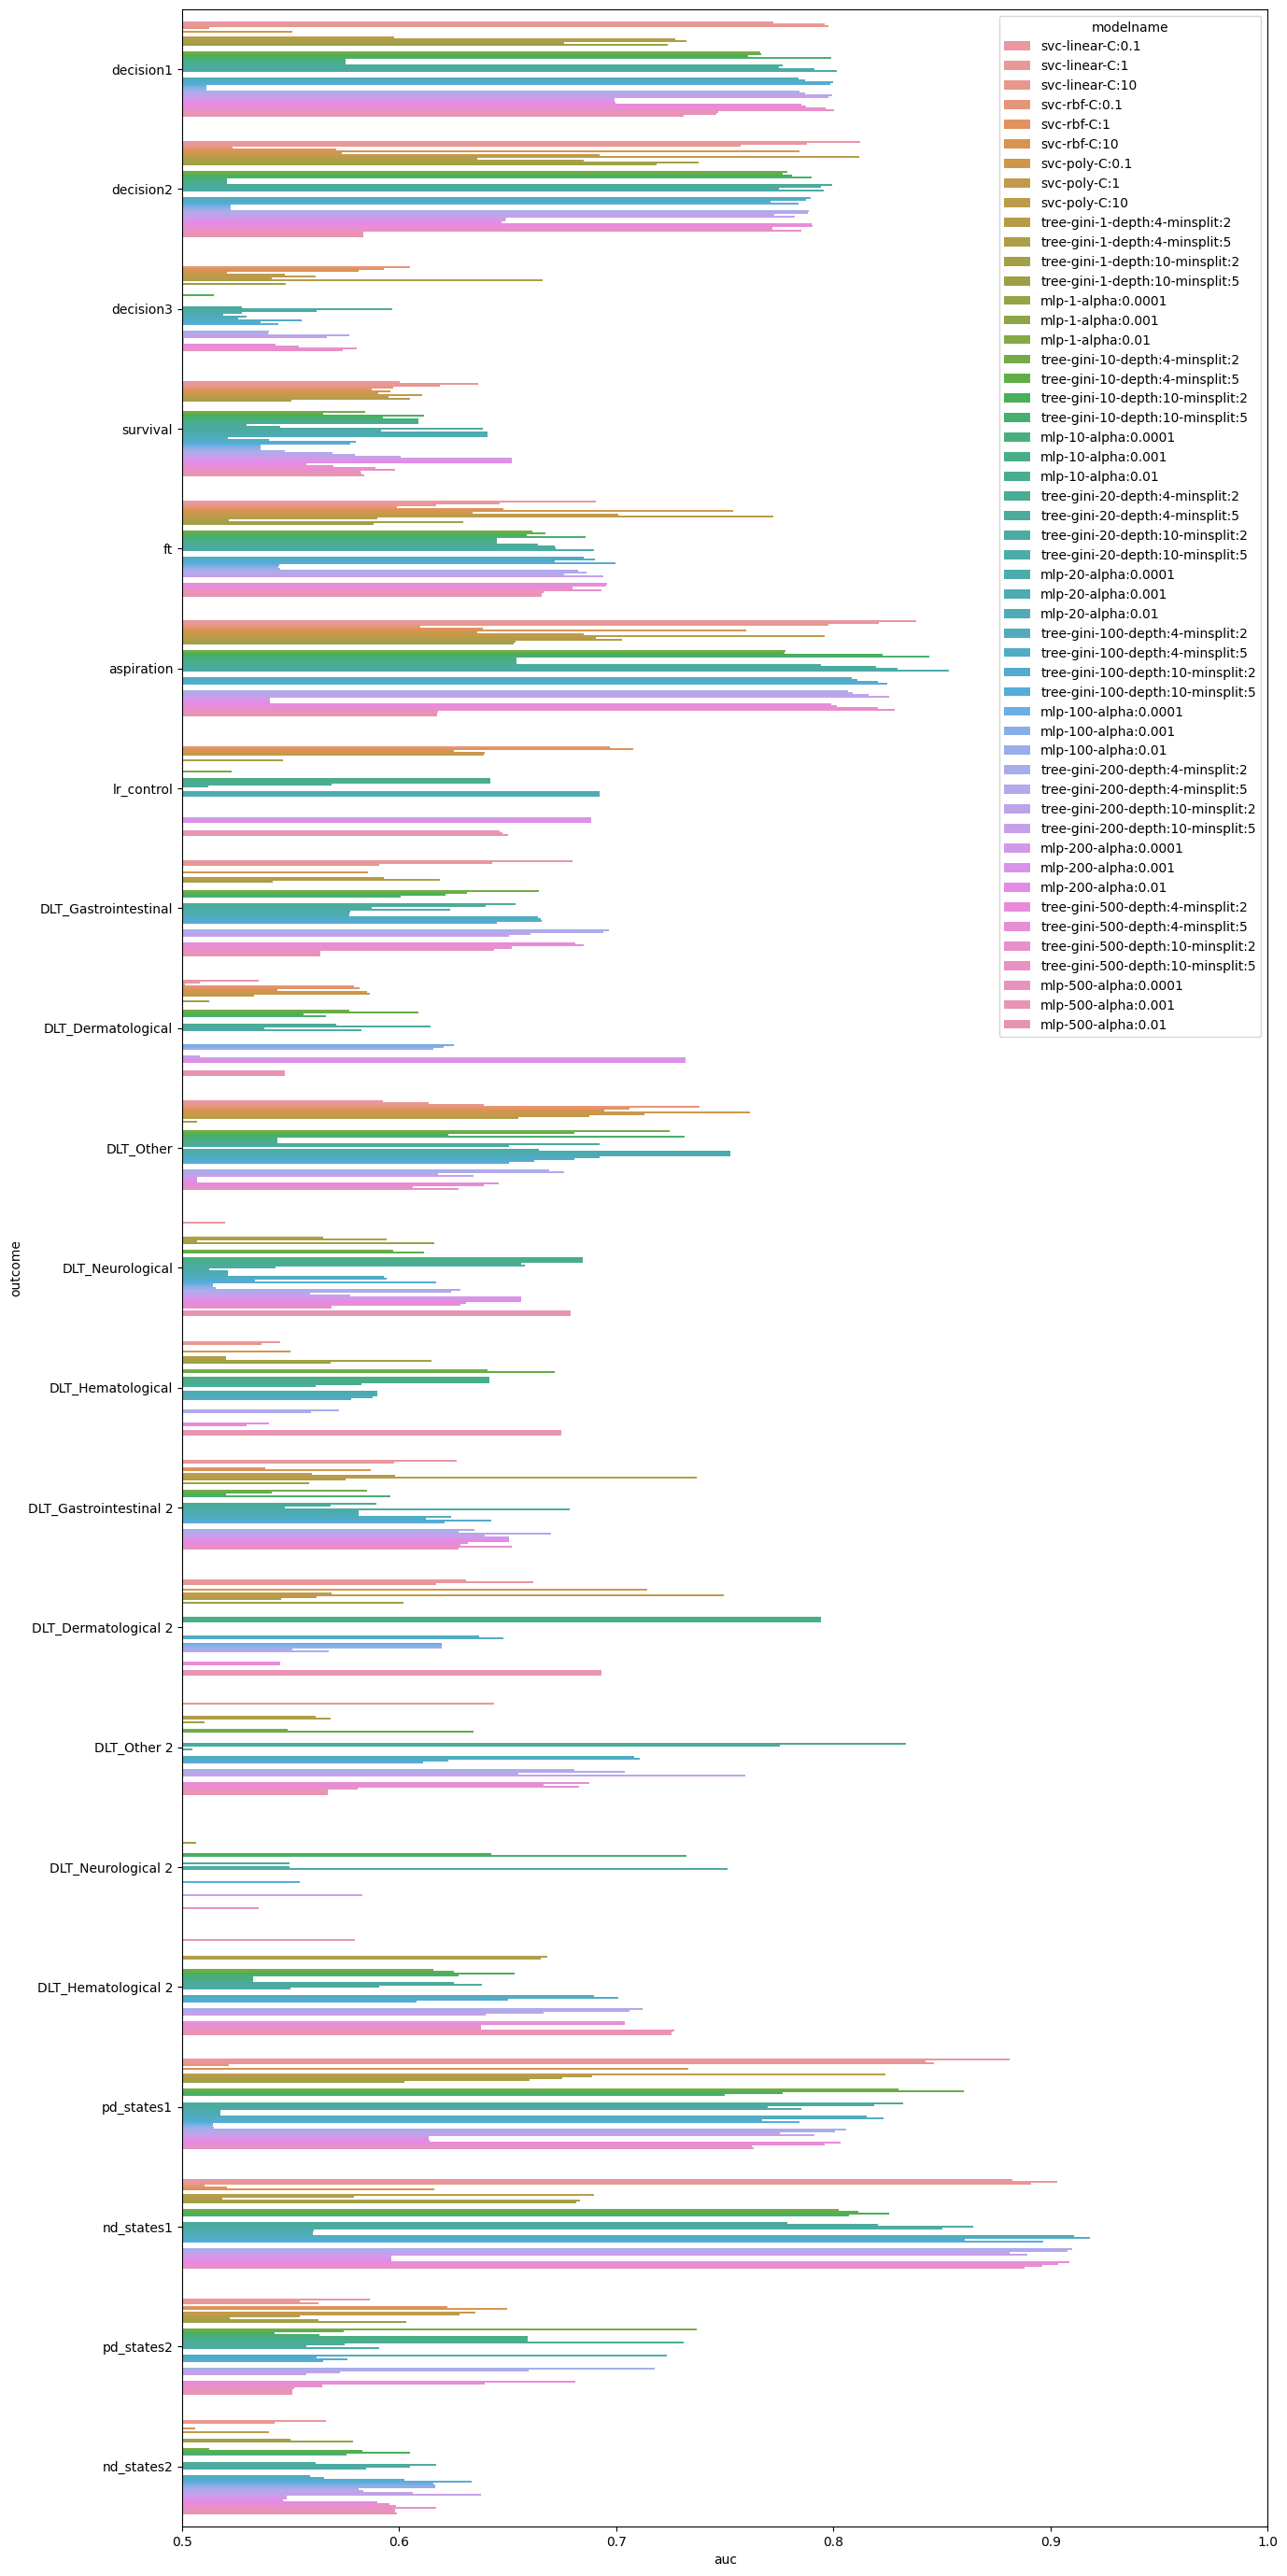

In [13]:
fig,ax = plt.subplots(1,1,figsize=(15,35))
sns.barplot(
    data=svc_results,
    y='outcome',
    hue='modelname',
    x='auc',
    orient='h',
)
ax.set_xlim(.5,1)

In [ ]:
best_models = {}
for outcome, subdf in svc_results[(svc_results.modelname != 'nca') & (svc_results.modelname != 'bayewrapper')].groupby('outcome'):
    best = subdf.sort_values('auc',ascending=False)[subdf.auc >= subdf.auc.max() - .01]
    print(outcome,best[['modelname','auc']])
    print('----')
    best_models[outcome] = list(best['model'].values[:3])
best_models['lr_control']

In [ ]:
for k,v in best_models.items():
    print(k)
    print(v)
    print('_____________\n')
    

In [24]:
def make_transition_model(models,data,state=1):
    targets = ['pd_states'+str(state),'nd_states'+str(state)]
    groupname = ''
    if state == 1:
        targets = ['pd_states1','nd_states1','modifications']
        dlts = Const.dlt1
        groupname = 'dlt1'
    elif state == 2:
        targets = ['pd_states2','nd_states2','ccs']
        dlts = Const.dlt2
        groupname = 'dlt2'
    else:
        assert state == 3
        targets = ['survival','ft','aspiration','lr_control']
        dlts = []
    models = models[:len(targets+dlts)]
    assert len(models) == len(targets+dlts)
    ensembles = [SingleOutcomeEnsembleWrapper(mlist,target) for mlist,target in zip(models,targets+dlts)]
    to_group = dlts if state < 3 else []
    tmodel = OutcomeEnsembleWrapper(ensembles, to_group = to_group,groupname=groupname,state=state)
    train_ids, test_ids = get_tt_split(dataset)
    xtrain = dataset.get_input_state(step=state,ids=train_ids)
    xtest = dataset.get_input_state(step=state,ids=test_ids)
    ytrains = [dataset.get_state(target,ids=train_ids) for target in targets]
    ytests = [dataset.get_state(target,ids=test_ids) for target in targets]
    for dlt in dlts:
        ydlt = data.processed_df[dlt]
        ytrains.append(ydlt.loc[train_ids])
        ytests.append(ydlt.loc[test_ids])
    xtrain = xtrain.values
    ytrains = [yy.values for yy in ytrains]
    tmodel.fit_models(xtrain,ytrains)
    ypred = tmodel(xtest)
    res = {}
    print(ypred['order'])
    for i, target in enumerate(targets):
        if target != ypred['order'][i]:
            print(target,ypred)
        if state == 3:
            yp = ypred['predictions'][:,i]
        else:
            yp = ypred['predictions'][i]
        yt = ytests[i]
        yp = yp.cpu().detach().numpy()
        try:
            if yp.ndim > 1:
                if yt.shape[0] > 1:
                    yt = np.argmax(yt.values,axis=1)
                res[target] = baseline_mc_metrics(yt,yp)
            else:
                res[target] = boolean_metrics(yt,yp)
        except Exception as e:
            print('error in ',ypred['order'][i],yp.shape)
            print(e)
            print('')
    if len(dlts) > 0:
        startpos = ypred['order'].index(groupname)
        ydlt = ypred['predictions'][startpos]
        for ii,dltname in enumerate(dlts):
            yp = ydlt[:,ii].cpu().detach().numpy()
            yt = ytests[ii+startpos]
            print(dltname,yt.mean())
            res[dltname] = boolean_metrics(yt,yp)
    return tmodel, res

def get_all_transition_models(model_dict,data):
    state1_vars = ['pd_states1','nd_states1','modifications'] + Const.dlt1
    state2_vars = ['pd_states2','nd_states2','ccs'] + Const.dlt2
    state3_vars = ['survival','ft','aspiration','lr_control']
    getdefault = lambda : [SVC(probability=True,class_weight='balanced',kernel='linear')]
    
    s1_models = [model_dict.get(name) if name in model_dict else getdefault() for name in state1_vars]
    s2_models = [model_dict.get(name) if name in model_dict else getdefault() for name in state2_vars]
    s3_models = [model_dict.get(name) if name in model_dict else getdefault() for name in state3_vars]
    
    t1,t1_res = make_transition_model(s1_models,data,state=1)
    print(t1_res)
    print('_____________')
    t2,t2_res = make_transition_model(s2_models,data,state=2)
    print(t2_res)
    print('_____________')
    t3,t3_res = make_transition_model(s3_models,data,state=3)
    print(t3_res)
    print('_____________')
    results = {
        1: t1_res,
        2: t2_res,
        3: t3_res
    }
    return [t1,t2,t3], results

from Models import *
testmodels, testresults = get_all_transition_models(best_models,dataset)
testresults

['pd_states1', 'nd_states1', 'modifications', 'dlt1']
DLT_Other 0.02040816326530612
DLT_Hematological 0.08163265306122448
DLT_Neurological 0.034013605442176874
DLT_Dermatological 0.04081632653061224
DLT_Gastrointestinal 0.07482993197278912
{'pd_states1': {'accuracy': 0.4997198879551821, 'auc_micro': 0.8812458662882275, 'auc_mean': 0.8812458662882275, 'auc_weighted': 0.9043652785079684}, 'nd_states1': {'accuracy': 0.6366666666666667, 'auc_micro': 0.9150657224080415, 'auc_mean': 0.9150657224080415, 'auc_weighted': 0.9508599171725888}, 'modifications': {'accuracy': 0.16666666666666666, 'auc_micro': 0.8471535781234185, 'auc_mean': 0.8471535781234185, 'auc_weighted': 0.865068473884032}, 'DLT_Other': {'auc': 0.3310185185185185, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}, 'DLT_Hematological': {'auc': 0.4574074074074074, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}, 'DLT_Neurological': {'auc': 0.6619718309859155, 'f1': 0.0, 'precision': 0.0, 'recall': 0.0}, 'DLT_Dermatological': {'auc': 0.7387

{1: {'pd_states1': {'accuracy': 0.4997198879551821,
   'auc_micro': 0.8812458662882275,
   'auc_mean': 0.8812458662882275,
   'auc_weighted': 0.9043652785079684},
  'nd_states1': {'accuracy': 0.6366666666666667,
   'auc_micro': 0.9150657224080415,
   'auc_mean': 0.9150657224080415,
   'auc_weighted': 0.9508599171725888},
  'modifications': {'accuracy': 0.16666666666666666,
   'auc_micro': 0.8471535781234185,
   'auc_mean': 0.8471535781234185,
   'auc_weighted': 0.865068473884032},
  'DLT_Other': {'auc': 0.3310185185185185,
   'f1': 0.0,
   'precision': 0.0,
   'recall': 0.0},
  'DLT_Hematological': {'auc': 0.4574074074074074,
   'f1': 0.0,
   'precision': 0.0,
   'recall': 0.0},
  'DLT_Neurological': {'auc': 0.6619718309859155,
   'f1': 0.0,
   'precision': 0.0,
   'recall': 0.0},
  'DLT_Dermatological': {'auc': 0.7387706855791962,
   'f1': 0.0,
   'precision': 0.0,
   'recall': 0.0},
  'DLT_Gastrointestinal': {'auc': 0.8562834224598931,
   'f1': 0.0,
   'precision': 0.0,
   'recall': 

In [25]:
import pickle
def save_sklearn_transition_models(t1,t2,t3):
    model_names = ['transition1_model.pickle','transition2_model.pickle','outcome_model.pickle']
    success = []
    for mname,model in zip(model_names,[t1,t2,t3]):
        try:
            name = '../resources/sklearn_models/' + mname
            with open(name,'wb') as f:
                pickle.dump(model,f,protocol=pickle.HIGHEST_PROTOCOL)
            success.append(name)
        except Exception as e:
            success.append(False)
            print(e)
    return success
save_sklearn_transition_models(*testmodels)

['../resources/sklearn_models/transition1_model.pickle',
 '../resources/sklearn_models/transition2_model.pickle',
 '../resources/sklearn_models/outcome_model.pickle']

In [ ]:
def load_sklearn_transition_models():
    model_names = ['transition1_model.pickle','transition2_model.pickle','outcome_model.pickle']
    success = []
    for mname in model_names:
        try:
            name = '../resources/sklearn_models/' + mname
            with open(name,'rb') as f:
                model = pickle.load(f)
            success.append(model)
        except Exception as e:
            success.append(False)
            print(e)
    return success
load_sklearn_transition_models()

In [ ]:
Const.dlt2